# (28) Variograms -- BrainSMASH

**Motivation**: Plot variograms for degree using BrainSMASH code (comes towards the end). <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, Latex

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
def default_props_anesth(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(512)
    mice.set_kws(
        desc_ca2='preproc',
        desc_bold='rabies-hp',
    )
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca


def _get_avg_deg_ca(mice):
    deg = {}
    for b in bands:
        mice.set_kws(band_ca2=b)
        d = collect_degrees_lite(
            mice=mice,
            mode='ca2',
            rho=0.15,
            filter_isolated=True,
        )
        x = np.stack(list(d.values()))
        deg[b] = bn.nanmean(x, 0)
    deg = {
        f"{bands[b]}\n{b}": d
        for b, d in deg.items()
    }
    return deg

## Prep

In [3]:
bs = Base(Mice(512), mode='ca2')
kws_show = show_kws(7)
bands = {
    (0.0, 5.0): 'Unfiltered',
    (0.01, 5.0): 'HP',
    (0.01, 0.5): CAS,
    (0.5, 5.0): CAF,
}
fig_dir = pjoin(fig_base_dir, 'rebuttal')
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal

## Ca$^{2+}$,  *anesth*

In [4]:
mice_anesth, _ = default_props_anesth()
mice_anesth.kws

{
    'task': 'rest',
    'exclude': True,
    'runs_only': True,
    'band_ca2': (0.01, 5.0),
    'band_bold': (0.01, 0.5),
    'desc_ca2': 'preproc',
    'desc_bold': 'rabies-hp'
}

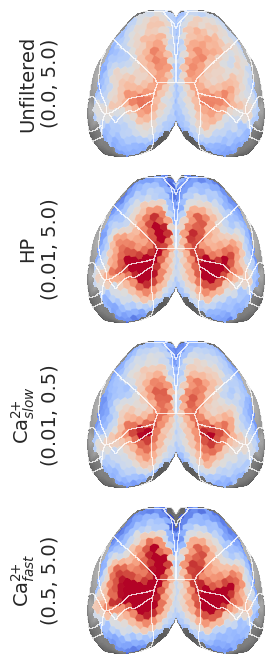

In [5]:
deg_anesth = _get_avg_deg_ca(mice_anesth)
bs.show(deg_anesth, vmin=0, vmax=160, cmap='coolwarm');

## Bold-lite

In [6]:
mice = Mice(512)
mice.kws

{
    'task': 'rest',
    'exclude': True,
    'runs_only': True,
    'band_ca2': (0.01, 5.0),
    'band_bold': (0.01, 0.5),
    'desc_ca2': 'preproc',
    'desc_bold': 'rabies-hp'
}

In [7]:
deg_bold = collect_degrees_lite(
    mice=mice,
    mode='bold-lite',
    rho=0.15,
    filter_isolated=True,
)
deg_bold = bn.nanmean(np.stack(list(
    deg_bold.values())), 0)

In [8]:
vmax = np.nanmax(deg_bold)
vmax

123.64545454545454

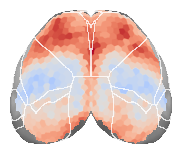

In [9]:
bs.show(deg_bold, vmin=0, vmax=vmax, cmap='coolwarm');

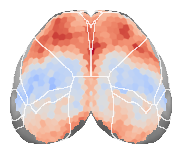

In [9]:
# was before fixing that 'eroded' bug

## Variogram

In [10]:
ids_present = np.array(list(
    mice.node_lookup['ca2'].values()))

### Pairwise distances

In [11]:
top, _ = mice.parcel.load_top_flat()
pixel_coords = unique_idxs(top)

com = {}
for i, p in pixel_coords.items():
    if i not in bs.id2n:
        continue
    points = np.array(list(zip(*np.unravel_index(
        p, top.shape))))
    com[i] = points.mean(0)
len(com)

540

#### plot CoM, make sure correct

In [12]:
ii = ids_present[86]

In [13]:
points = np.array(list(zip(*np.unravel_index(
    pixel_coords[ii],
    top.shape,
))))

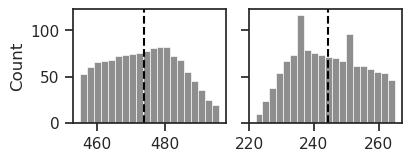

In [14]:
fig, axes = create_figure(1, 2, (4, 1.5), sharey='all', layout='constrained')
for i in range(2):
    sns.histplot(points[:, i], bins=20, color='dimgrey', ax=axes[i])
    axes[i].axvline(points.mean(0)[i], color='k', ls='--')
plt.show()

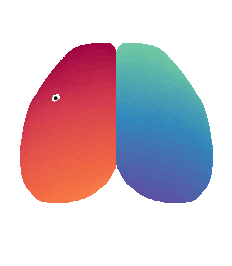

In [15]:
fig, ax = create_figure()
ax.imshow(mwh(np.isin(top, [0, ii]), top), cmap='Spectral')
ax.add_patch(matplotlib.patches.Circle(com[ii][::-1], radius=6, color='k'))
remove_ticks(ax)
plt.show()

## Results, deg

In [16]:
deg = {
    BOLD: deg_bold,
    CAS: deg_anesth[f"{CAS}\n(0.01, 0.5)"],
    CAF: deg_anesth[f"{CAF}\n(0.5, 5.0)"],
}

In [17]:
ids_present_left = mice.parcel.df.loc[
    (mice.parcel.df['hemis'] == 1) &
    (mice.parcel.df['id'].isin(com)),
    'id'
].values
len(ids_present_left)

270

In [18]:
distances_left = {
    (i, j): np.linalg.norm(com[i] - com[j]) for i, j
    in itertools.combinations(ids_present_left, 2)
}
len(distances_left)

36315

In [19]:
delta = 50

num = 100
span = np.linspace(
    min(distances_left.values()),
    max(distances_left.values()),
    num=num,
)
gamma = {
    k: np.zeros(num)
    for k in deg
}
for i0, h in enumerate(span):
    neighbors = dict(filter(
        lambda t: h - delta < t[1] < h + delta,
        distances_left.items(),
    ))
    for mode, d in deg.items():
        var = np_nans(len(neighbors))
        for ctr, (i, j) in enumerate(neighbors):
            xi = d[bs.id2n[i]]
            xj = d[bs.id2n[j]]
            var[ctr] = (xi - xj) ** 2
        var = np.nanmean(var)
        gamma[mode][i0] = var

## Degree rank

### BOLD

In [20]:
deg_bold = collect_degrees_lite(
    mice=mice,
    mode='bold-lite',
    rho=0.15,
    filter_isolated=True,
)
deg_bold = np.stack(list(
    deg_bold.values()))

dr_bold = np_nans(deg_bold.shape)
for i, x in enumerate(deg_bold):
    good = np.isfinite(x)
    if not good.sum():
        continue
    _ranked = sp_stats.rankdata(x[good])
    _ranked /= np.nanmax(_ranked)
    dr_bold[i, good] = _ranked
dr_bold = bn.nanmean(dr_bold, 0)

### CAS

In [21]:
mice_anesth.set_kws(band_ca2=(0.01, 0.5))
deg_cas = collect_degrees_lite(
    mice=mice_anesth,
    mode='ca2',
    rho=0.15,
    filter_isolated=True,
)
deg_cas = np.stack(list(
    deg_cas.values()))

dr_cas = np_nans(deg_cas.shape)
for i, x in enumerate(deg_cas):
    good = np.isfinite(x)
    if not good.sum():
        continue
    _ranked = sp_stats.rankdata(x[good])
    _ranked /= np.nanmax(_ranked)
    dr_cas[i, good] = _ranked
dr_cas = bn.nanmean(dr_cas, 0)

### CAF

In [22]:
mice_anesth.set_kws(band_ca2=(0.5, 5.0))
deg_caf = collect_degrees_lite(
    mice=mice_anesth,
    mode='ca2',
    rho=0.15,
    filter_isolated=True,
)
deg_caf = np.stack(list(
    deg_caf.values()))

dr_caf = np_nans(deg_caf.shape)
for i, x in enumerate(deg_caf):
    good = np.isfinite(x)
    if not good.sum():
        continue
    _ranked = sp_stats.rankdata(x[good])
    _ranked /= np.nanmax(_ranked)
    dr_caf[i, good] = _ranked
dr_caf = bn.nanmean(dr_caf, 0)

In [54]:
d = {
    'BOLD': bn.nanmean(deg_bold, 0),
    'CAS': bn.nanmean(deg_cas, 0),
    'CAF': bn.nanmean(deg_caf, 0),
}
dr = {
    'BOLD': dr_bold,
    'CAS': dr_cas,
    'CAF': dr_caf,
}

In [38]:
{k: (np.nanmin(v), np.nanmax(v)) for k, v in dr.items()}

{
    'BOLD': (0.21269394878330333, 0.7681680279339376),
    'CAS': (0.07455426045514849, 0.9314761472712783),
    'CAF': (0.009846819005735, 0.9645000892574231)
}

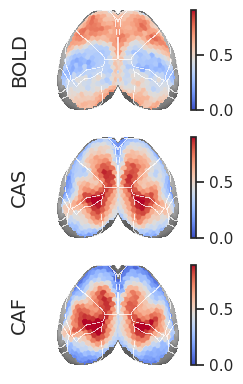

In [39]:
bs.show(dr, vmin=0, vmax=0.9, figsize=(3, 4), cmap='coolwarm', cbar=True);

In [40]:
{k: (np.nanmin(v), np.nanmax(v)) for k, v in d.items()}

{
    'BOLD': (42.44736842105263, 123.64545454545454),
    'CAS': (14.851063829787234, 161.45045045045046),
    'CAF': (1.5, 196.04504504504504)
}

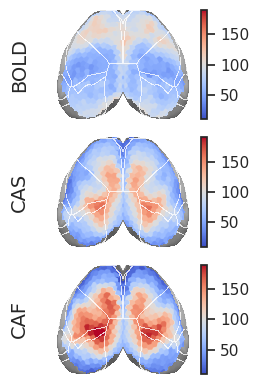

In [43]:
bs.show(d, vmin=10, vmax=190, figsize=(3, 4), cmap='coolwarm', cbar=True);

In [26]:
delta = 50

num = 100
span = np.linspace(
    min(distances_left.values()),
    max(distances_left.values()),
    num=num,
)
gamma = {
    k: np.zeros(num)
    for k in dr
}
for i0, h in enumerate(span):
    neighbors = dict(filter(
        lambda t: h - delta < t[1] < h + delta,
        distances_left.items(),
    ))
    for mode, d in dr.items():
        var = np_nans(len(neighbors))
        for ctr, (i, j) in enumerate(neighbors):
            xi = d[bs.id2n[i]]
            xj = d[bs.id2n[j]]
            var[ctr] = (xi - xj) ** 2
        var = np.nanmean(var)
        gamma[mode][i0] = var

In [27]:
translation = {'BOLD': BOLD, 'CAS': CAS, 'CAF': CAF}
pal = prepare_palette()

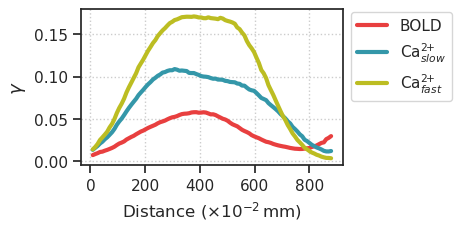

In [28]:
fig, ax = create_figure(1, 1, (4.5, 2.2), sharey='all', layout='constrained')
for i, mode in enumerate(gamma):
    ax.plot(
        span,
        gamma[mode],
        color=pal[translation[mode]],
        label=translation[mode],
        lw=3,
    )
ax.legend()
ax.set_ylabel(r'$\gamma$', fontsize=13)
ax.set_xlabel('Distance ' + r"$\left(\times 10^{-2} \, \mathrm{mm}\right)$")
move_legend(ax, (1., 1.03))
ax.grid()

fig.savefig(
    pjoin(fig_dir, f"variogram_degree_rank_together.pdf"),
    # bbox_extra_artists=[s],
    bbox_inches='tight',
    # dpi=200,
)
plt.show()

In [55]:
list(d), list(dr)

(['BOLD', 'CAS', 'CAF'], ['BOLD', 'CAS', 'CAF'])

In [44]:
_ = save_obj(
    obj=d,
    file_name='degrees',
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'degrees.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [45]:
_ = save_obj(
    obj=dr,
    file_name='degree_ranks',
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'degree_ranks.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [46]:
_= save_obj(
    obj=distances_left,
    file_name='euclidean_dists_left_hemis',
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'euclidean_dists_left_hemis.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

## BrainSMASH

In [47]:
sys.path.insert(0, os.path.join(git_dir, 'brainsmash'))
from brainsmash.mapgen.base import Base as Brainsmash_BS

In [48]:
n = len(ids_present_left)
d_square = np.zeros((n, n))
for (src, tgt), d in distances_left.items():
    d_square[bs.id2n[src], bs.id2n[tgt]] = d
d_square += d_square.T

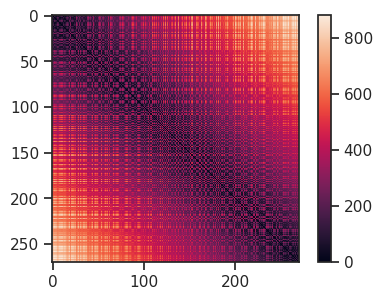

In [49]:
plt.imshow(d_square)
plt.colorbar();

In [50]:
nodes_present_left = np.array([
    bs.id2n[i] for i in
    ids_present_left
])

In [51]:
gamma = {}
for k, d in dr.items():
    x = d[nodes_present_left]
    good = ~np.isnan(x)
    x = x[good]

    base = Brainsmash_BS(x, d_square[good][:, good], nh=25, pv=40)
    gamma[k] = base.compute_smooth_variogram(x)

In [ ]:
"""fig, ax = create_figure(1, 1, (4.5, 3.1), sharey='all', layout='constrained')
for i, mode in enumerate(gamma):
    ax.plot(
        base.h / 100,
        gamma[mode],
        color=pal[translation[mode]],
        label=translation[mode],
        marker='o',
        lw=1,
    )
ax.legend()
ax.set_ylabel(r'$\gamma$', fontsize=15)
ax.set_xlabel('Distance (mm)')
move_legend(ax, (1., 1.03))
ax.grid()

fig.savefig(
    pjoin(fig_dir, f"variogram_brainsmash_degree_rank.pdf"),
    bbox_inches='tight',
)
plt.show()"""

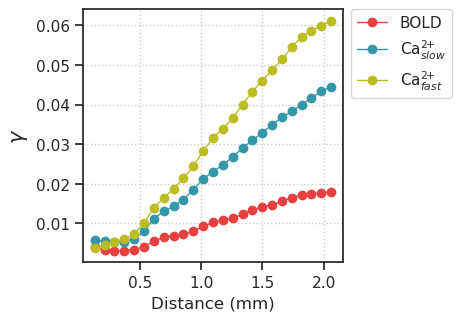